<a href="https://colab.research.google.com/github/dc-neo/movie_plot/blob/main/end_to_end_model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model Selection
```
# This is formatted as code
```



In [113]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.13.*"

In [114]:
!pip install -q -U "tf-models-official==2.13.*"

In [115]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [116]:
from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [117]:
import os
os.getcwd()
os.chdir('/content/gdrive/MyDrive/Colab Notebooks')
os.getcwd()

'/content/gdrive/MyDrive/Colab Notebooks'

Read the cleaned text plot, balanced dataframe from the database.

In [118]:
import sqlite3
import pandas as pd
sql = """
SELECT p.* FROM plot_nlp p
"""
with sqlite3.connect('movie_plots.db') as con:
    df = pd.read_sql_query(sql, con)

In [119]:
df.head()

index  release_year             title originethnicity  \
0      0          1997          Arasiyal           Tamil   
1      1          2002  Yeh Mohabbat Hai       Bollywood   
2      2          2010     Aridhu Aridhu           Tamil   
3      3          2011            Varnam           Tamil   
4      4          2012    Les Misérables         British   

               director                                               cast  \
0       R. K. Selvamani              Mammootty, Shilpa Shirodkar, Roja\r\n   
1               Unknown                          Rahul Bhatt, Johnny Lever   
2     K. R. Mathivannan        Harish Kalyan, Uttara Raj, Princess Jasmine   
3            S. M. Raju                Giri, Ashwatha, Monica, Sampath Raj   
4  Director: Tom Hooper  Director: Tom Hooper\r\nCast: Hugh Jackman, Ru...   

     genre                                          wiki_page  \
0  unknown             https://en.wikipedia.org/wiki/Arasiyal   
1  unknown     https://en.wikipedia.org/wiki/Yeh_Mohabbat_Hai   
2  unknown        https://en.wikipedia.org/wiki/Aridhu_Aridhu   
3  unknown   https://en.wikipedia.org/wiki/Varnam_(2011_film)   
4  unknown  https://en.wikipedia.org/wiki/Les_Mis%C3%A9rab...   

                                                plot  \
0  Chandrasekhar (Mammootty) is an honest collect...   
1  Yeh Mohabbat Hai revolves around Chand & Shahe...   
2  The film has been shot in Chennai, Australia a...   
3  Mani (Giri) becomes a spoiled brat after his f...   
4  In 1815, French prisoner Jean Valjean is relea...   

                                          plot_clean  \
0  Chandrasekhar (Mammootty) is an honest collect...   
1  Yeh Mohabbat Hai revolves around Chand & Shahe...   
2  The film has been shot in Chennai, Australia a...   
3  Mani (Giri) becomes a spoiled brat after his f...   
4  In 1815, French prisoner Jean Valjean is relea...   

                                          plot_lemma  \
0  Chandrasekhar ( Mammootty ) be an honest colle...   
1  Yeh Mohabbat Hai revolve around Chand & Shahee...   
2  the film have be shoot in Chennai , Australia ...   
3  Mani ( Giri ) become a spoiled brat after his ...   
4  in 1815 , french prisoner Jean Valjean be rele...   

                                          plot_nouns  \
0  Chandrasekhar Mammootty collector Vikram Anand...   
1  Yeh Mohabbat Hai Chand Shaheen lover childhood...   
2  film Chennai Australia New Zealand film terror...   
3  Mani Giri brat father death caste clash Mani m...   
4  prisoner Jean Valjean parole Bagne Toulon year...   

                                     plot_adjectives  \
0  honest international hopeless corrupt honest a...   
1                       opposite sufficient innocent   
2                                                      
3                              spoiled rich own dear   
4  french multiple kindly worthwhile valjean new ...   

                                          plot_verbs  \
0  arrest transfer eradicate have meet suspect ta...   
1  revolve gather play trap claim have convict be...   
2                                  shoot deal happen   
3  become send enjoy wait revenge fall influence ...   
4  release serve steal try escape parole prevent ...   

                                            plot_nav  no_tokens  
0  Chandrasekhar Mammootty collector Vikram Anand...        327  
1  Yeh Mohabbat Hai Chand Shaheen lover childhood...        113  
2  film Chennai Australia New Zealand film terror...         27  
3  Mani Giri brat father death caste clash Mani m...        169  
4  prisoner Jean Valjean parole Bagne Toulon year...        739

In [120]:
df.describe()

index  release_year    no_tokens
count  4960.000000   4960.000000  4960.000000
mean   2479.500000   1973.991532   438.094960
std    1431.972998     27.960771   372.796916
min       0.000000   1902.000000     6.000000
25%    1239.750000   1950.000000   140.000000
50%    2479.500000   1973.000000   336.000000
75%    3719.250000   2001.000000   697.000000
max    4959.000000   2017.000000  5893.000000

In [121]:
df = df.rename(columns={"plot": "plot_describe"})

In [122]:
df['genre'].unique()

array(['unknown', 'drama', 'comedy', 'horror', 'action', 'thriller',
       'romance', 'western', 'crime', 'adventure', 'musical',
       'crime drama', 'romantic comedy', 'science fiction', 'film noir',
       'mystery'], dtype=object)

In [123]:
value_map = {'crime drama': 'crime|drama', 'romantic comedy': 'romantic|comedy', 'science fiction': 'science|fiction', 'film noir' : 'film|noir'}
df['genre_corrected'] = df['genre'].replace(value_map)

In [124]:
df['count']=1
df[['genre','count']].groupby(['genre'], as_index=False).count().shape[0]

16

In [125]:
import numpy as np
df['genre_split']=df['genre_corrected'].str.split('|')
df['genre_split']= df['genre_split'].apply(np.sort).apply(np.unique)

In [126]:
total_count = df.shape[0]
genre_counts = df['genre_split'].value_counts()
total_count

4960

In [127]:
genre_counts.values/total_count

array([0.0625    , 0.0625    , 0.0625    , ..., 0.00020161, 0.00020161,
       0.00020161])

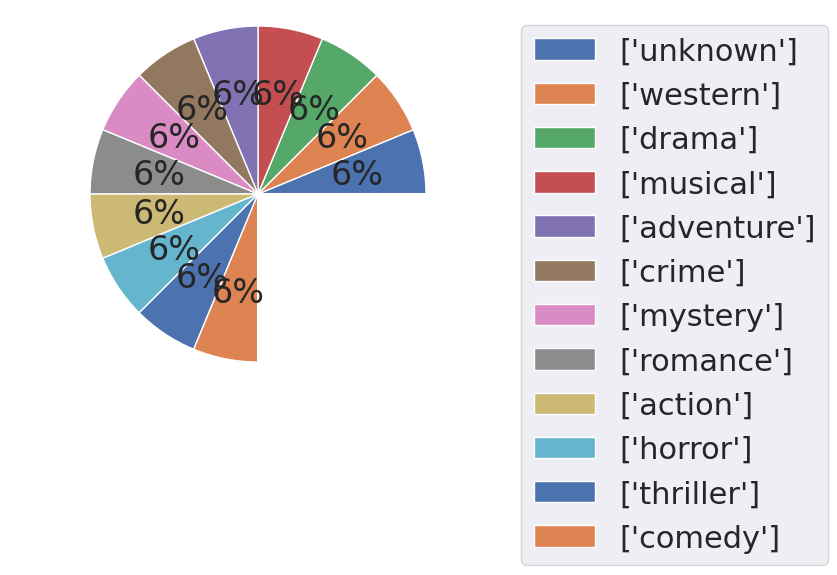

In [128]:
import matplotlib.pyplot as plt
import numpy as np

sizes = pd.DataFrame(genre_counts.values/total_count, index = genre_counts.index)

fig1, ax = plt.subplots()
def autopct_more_than_1(pct):
    return ('%1.f%%' % pct) if pct > 0.5 else ''

p,t,a = ax.pie(sizes.values.reshape(1,-1)[0], autopct=autopct_more_than_1)
ax.axis('equal')

# normalize dataframe (not actually needed here, but for general case)
normsizes = sizes/sizes.sum()*100
# create handles and labels for legend, take only those where value is > 1
h,l = zip(*[(h,lab) for h,lab,i in zip(p,sizes.index.values,normsizes.values) if i > 1])

ax.legend(h, l,loc="best", bbox_to_anchor=(1,1))
plt.show()

In [129]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [130]:
df['plot_clean'] = df['plot_describe'].apply(clean_text)

In [131]:
df.head()

index  release_year             title originethnicity  \
0      0          1997          Arasiyal           Tamil   
1      1          2002  Yeh Mohabbat Hai       Bollywood   
2      2          2010     Aridhu Aridhu           Tamil   
3      3          2011            Varnam           Tamil   
4      4          2012    Les Misérables         British   

               director                                               cast  \
0       R. K. Selvamani              Mammootty, Shilpa Shirodkar, Roja\r\n   
1               Unknown                          Rahul Bhatt, Johnny Lever   
2     K. R. Mathivannan        Harish Kalyan, Uttara Raj, Princess Jasmine   
3            S. M. Raju                Giri, Ashwatha, Monica, Sampath Raj   
4  Director: Tom Hooper  Director: Tom Hooper\r\nCast: Hugh Jackman, Ru...   

     genre                                          wiki_page  \
0  unknown             https://en.wikipedia.org/wiki/Arasiyal   
1  unknown     https://en.wikipedia.org/wiki/Yeh_Mohabbat_Hai   
2  unknown        https://en.wikipedia.org/wiki/Aridhu_Aridhu   
3  unknown   https://en.wikipedia.org/wiki/Varnam_(2011_film)   
4  unknown  https://en.wikipedia.org/wiki/Les_Mis%C3%A9rab...   

                                       plot_describe  \
0  Chandrasekhar (Mammootty) is an honest collect...   
1  Yeh Mohabbat Hai revolves around Chand & Shahe...   
2  The film has been shot in Chennai, Australia a...   
3  Mani (Giri) becomes a spoiled brat after his f...   
4  In 1815, French prisoner Jean Valjean is relea...   

                                          plot_clean  \
0  chandrasekhar mammootty is an honest collector...   
1  yeh mohabbat hai revolves around chand shaheen...   
2  the film has been shot in chennai australia an...   
3  mani giri becomes a spoiled brat after his fat...   
4  in 1815 french prisoner jean valjean is releas...   

                                          plot_lemma  \
0  Chandrasekhar ( Mammootty ) be an honest colle...   
1  Yeh Mohabbat Hai revolve around Chand & Shahee...   
2  the film have be shoot in Chennai , Australia ...   
3  Mani ( Giri ) become a spoiled brat after his ...   
4  in 1815 , french prisoner Jean Valjean be rele...   

                                          plot_nouns  \
0  Chandrasekhar Mammootty collector Vikram Anand...   
1  Yeh Mohabbat Hai Chand Shaheen lover childhood...   
2  film Chennai Australia New Zealand film terror...   
3  Mani Giri brat father death caste clash Mani m...   
4  prisoner Jean Valjean parole Bagne Toulon year...   

                                     plot_adjectives  \
0  honest international hopeless corrupt honest a...   
1                       opposite sufficient innocent   
2                                                      
3                              spoiled rich own dear   
4  french multiple kindly worthwhile valjean new ...   

                                          plot_verbs  \
0  arrest transfer eradicate have meet suspect ta...   
1  revolve gather play trap claim have convict be...   
2                                  shoot deal happen   
3  become send enjoy wait revenge fall influence ...   
4  release serve steal try escape parole prevent ...   

                                            plot_nav  no_tokens  \
0  Chandrasekhar Mammootty collector Vikram Anand...        327   
1  Yeh Mohabbat Hai Chand Shaheen lover childhood...        113   
2  film Chennai Australia New Zealand film terror...         27   
3  Mani Giri brat father death caste clash Mani m...        169   
4  prisoner Jean Valjean parole Bagne Toulon year...        739   

  genre_corrected  count genre_split  
0         unknown      1   [unknown]  
1         unknown      1   [unknown]  
2         unknown      1   [unknown]  
3         unknown      1   [unknown]  
4         unknown      1   [unknown]

In [132]:
import pandas as pd

# Perform one-hot encoding using get_dummies
encoded_columns = pd.get_dummies(df['genre'])

# Concatenate the one-hot encoded columns with the original DataFrame
df = pd.concat([df, encoded_columns], axis=1)

# Drop the original categorical column if needed
#df_encoded = df_encoded.drop('Category', axis=1)

# Display the resulting DataFrame
df.head()

index  release_year             title originethnicity  \
0      0          1997          Arasiyal           Tamil   
1      1          2002  Yeh Mohabbat Hai       Bollywood   
2      2          2010     Aridhu Aridhu           Tamil   
3      3          2011            Varnam           Tamil   
4      4          2012    Les Misérables         British   

               director                                               cast  \
0       R. K. Selvamani              Mammootty, Shilpa Shirodkar, Roja\r\n   
1               Unknown                          Rahul Bhatt, Johnny Lever   
2     K. R. Mathivannan        Harish Kalyan, Uttara Raj, Princess Jasmine   
3            S. M. Raju                Giri, Ashwatha, Monica, Sampath Raj   
4  Director: Tom Hooper  Director: Tom Hooper\r\nCast: Hugh Jackman, Ru...   

     genre                                          wiki_page  \
0  unknown             https://en.wikipedia.org/wiki/Arasiyal   
1  unknown     https://en.wikipedia.org/wiki/Yeh_Mohabbat_Hai   
2  unknown        https://en.wikipedia.org/wiki/Aridhu_Aridhu   
3  unknown   https://en.wikipedia.org/wiki/Varnam_(2011_film)   
4  unknown  https://en.wikipedia.org/wiki/Les_Mis%C3%A9rab...   

                                       plot_describe  \
0  Chandrasekhar (Mammootty) is an honest collect...   
1  Yeh Mohabbat Hai revolves around Chand & Shahe...   
2  The film has been shot in Chennai, Australia a...   
3  Mani (Giri) becomes a spoiled brat after his f...   
4  In 1815, French prisoner Jean Valjean is relea...   

                                          plot_clean  \
0  chandrasekhar mammootty is an honest collector...   
1  yeh mohabbat hai revolves around chand shaheen...   
2  the film has been shot in chennai australia an...   
3  mani giri becomes a spoiled brat after his fat...   
4  in 1815 french prisoner jean valjean is releas...   

                                          plot_lemma  \
0  Chandrasekhar ( Mammootty ) be an honest colle...   
1  Yeh Mohabbat Hai revolve around Chand & Shahee...   
2  the film have be shoot in Chennai , Australia ...   
3  Mani ( Giri ) become a spoiled brat after his ...   
4  in 1815 , french prisoner Jean Valjean be rele...   

                                          plot_nouns  \
0  Chandrasekhar Mammootty collector Vikram Anand...   
1  Yeh Mohabbat Hai Chand Shaheen lover childhood...   
2  film Chennai Australia New Zealand film terror...   
3  Mani Giri brat father death caste clash Mani m...   
4  prisoner Jean Valjean parole Bagne Toulon year...   

                                     plot_adjectives  \
0  honest international hopeless corrupt honest a...   
1                       opposite sufficient innocent   
2                                                      
3                              spoiled rich own dear   
4  french multiple kindly worthwhile valjean new ...   

                                          plot_verbs  \
0  arrest transfer eradicate have meet suspect ta...   
1  revolve gather play trap claim have convict be...   
2                                  shoot deal happen   
3  become send enjoy wait revenge fall influence ...   
4  release serve steal try escape parole prevent ...   

                                            plot_nav  no_tokens  \
0  Chandrasekhar Mammootty collector Vikram Anand...        327   
1  Yeh Mohabbat Hai Chand Shaheen lover childhood...        113   
2  film Chennai Australia New Zealand film terror...         27   
3  Mani Giri brat father death caste clash Mani m...        169   
4  prisoner Jean Valjean parole Bagne Toulon year...        739   

  genre_corrected  count genre_split  action  adventure  comedy  crime  \
0         unknown      1   [unknown]       0          0       0      0   
1         unknown      1   [unknown]       0          0       0      0   
2         unknown      1   [unknown]       0          0       0      0   
3         unknown      1   [unknown]       0          0      

Define the train, test and validation datasets

In [133]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, random_state=42, test_size=0.2, shuffle=True)
df_train, df_val = train_test_split(df_train, random_state=42, test_size=0.25, shuffle=True)

Methods for Prediction

TF_IDF and SVC

In [134]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
x_train = tfidf.fit_transform(df_train.plot_clean)
x_val  = tfidf.transform(df_val.plot_clean)
x_test  = tfidf.transform(df_test.plot_clean)

In [135]:
y_train = df_train.iloc[:, 19:35]
y_val = df_val.iloc[:, 19:35]
y_test = df_val.iloc[:, 19:35]
y_train

action  adventure  comedy  crime  crime drama  drama  film noir  horror  \
1027       0          0       0      0            0      0          0       1   
611        0          0       0      0            0      1          0       0   
3593       0          0       0      0            1      0          0       0   
4036       0          0       0      0            0      0          0       0   
4275       0          0       0      0            0      0          0       0   
...      ...        ...     ...    ...          ...    ...        ...     ...   
1758       0          0       0      0            0      0          0       0   
2028       0          0       0      0            0      0          0       0   
2833       0          1       0      0            0      0          0       0   
4799       0          0       0      0            0      0          0       0   
872        0          0       1      0            0      0          0       0   

      musical  mystery  romance  romantic comedy  science fiction  thriller  \
1027        0        0        0                0                0         0   
611         0        0        0                0                0         0   
3593        0        0        0                0                0         0   
4036        0        0        0                0                1         0   
4275        0        0        0                0                1         0   
...       ...      ...      ...              ...              ...       ...   
1758        0        0        0                0                0         1   
2028        0        0        1                0                0         0   
2833        0        0        0                0                0         0   
4799        0        1        0                0                0         0   
872         0        0        0                0                0         0   

      unknown  western  
1027        0        0  
611         0        0  
3593        0        0  
4036        0        0  
4275        0        0  
...       ...      ...  
1758        0        0  
2028        0        0  
2833        0        0  
4799        0        0  
872         0        0  

[2976 rows x 16 columns]

In [136]:
df_train.head()

index  release_year              title originethnicity  \
1027   1027          1990    The First Power        American   
611     611          1952      Arctic Flight        American   
3593   3593          1990  Presumed Innocent        American   
4036   4036          1957  The Deadly Mantis        American   
4275   4275          2005           Æon Flux        American   

              director                                               cast  \
1027  Robert Resnikoff                               Lou Diamond Phillips   
611        Lew Landers                        Wayne Morris, Lola Albright   
3593    Alan J. Pakula  Harrison Ford, Greta Scacchi, Bonnie Bedelia, ...   
4036      Nathan Juran                      Craig Stevens, William Hopper   
4275      Karyn Kusama                                    Charlize Theron   

                genre                                          wiki_page  \
1027           horror      https://en.wikipedia.org/wiki/The_First_Power   
611             drama        https://en.wikipedia.org/wiki/Arctic_Flight   
3593      crime drama  https://en.wikipedia.org/wiki/Presumed_Innocen...   
4036  science fiction    https://en.wikipedia.org/wiki/The_Deadly_Mantis   
4275  science fiction  https://en.wikipedia.org/wiki/%C3%86on_Flux_(f...   

                                          plot_describe  \
1027  A sadistic serial killer, Patrick Channing (Je...   
611   In Kotzebue, Alaska, bush pilot Mike Wein (Way...   
3593  Rozat "Rusty" Sabich is a prosecutor and the r...   
4036  In the South Seas, a volcano explodes, eventua...   
4275  In 2011, a deadly pathogenic virus has killed ...   

                                             plot_clean  \
1027  a sadistic serial killer patrick channing jeff...   
611   in kotzebue alaska bush pilot mike wein wayne ...   
3593  rozat rusty sabich is a prosecutor and the rig...   
4036  in the south seas a volcano explodes eventuall...   
4275  in 2011 a deadly pathogenic virus has killed 9...   

                                             plot_lemma  \
1027  a sadistic serial killer , Patrick Channing ( ...   
611   in Kotzebue , Alaska , bush pilot Mike Wein ( ...   
3593  Rozat " Rusty " Sabich be a prosecutor and the...   
4036  in the South Seas , a volcano explode , eventu...   
4275  in 2011 , a deadly pathogenic virus have kill ...   

                                             plot_nouns  \
1027  killer Patrick Channing Jeff Kober Pentagram K...   
611   Kotzebue Alaska bush pilot Mike Wein Wayne Mor...   
3593  Rozat Rusty Sabich prosecutor hand man distric...   
4036  South Seas volcano North Pole iceberg ice cap ...   
4275  virus % Earth population survivor Earth year s...   

                                        plot_adjectives  \
1027  sadistic serial most large innocent specific d...   
611   worried happy short short frozen local catholi...   
3593  right rival married brief sexual little little...   
4036  polar long military military northern giant in...   
4275  deadly pathogenic late futuristic idyllic skil...   

                                             plot_verbs  \
1027  know kill engrave kill bring receive call get ...   
611   receive fly nurse own shoot land transport sle...   
3593  find rape murder insist take approach act leav...   
4036  explode cause shift melt pray trap begin stir ...   
4275  kill force regroup scatter wall rule destroy d...   

                                               plot_nav  no_tokens  \
1027  killer Patrick Channing Jeff Kober Pentagram K...        522   
611   Kotzebue Alaska bush pilot Mike Wein Wayne Mor...        428   
3593  Rozat Rusty Sabich prosecutor hand man distric...        790   
4036  South Seas volcano North Pole iceberg ice cap ...        904   
4275  virus % Earth population survivor Earth year s...        520   

      genre_corrected  count         genre_split  action  adventure  comedy  \
1027           horror      1            [horror]       0          0    

In [137]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier

metrics_LinearSVC = pd.DataFrame()

In [138]:
def save_results_iter(metrics, prediction, y_val, param_repr, param):
    """Function for saving one iteration of experiment results
       param_repr - param representation (C for SVM, alpha for Naive Bayes)
       param - param value
       metrics - dataframe where store results

       adds row like |C={param}|  |recall|  |precison|  |f1_score|  |jaccard_metric|  |roc_auc_score|
    """

    metrics.loc[f'{param_repr}={param}','recall'] = recall_score(y_val, np.round(prediction), average='macro')
    metrics.loc[f'{param_repr}={param}','precision'] = precision_score(y_val, np.round(prediction), average='macro')
    metrics.loc[f'{param_repr}={param}','f1_score'] = f1_score(y_val, np.round(prediction), average='macro')
    metrics.loc[f'{param_repr}={param}','jaccard_metric'] = jaccard_score(y_val, np.round(prediction), average='macro')
    metrics.loc[f'{param_repr}={param}','roc_auc_score'] = roc_auc_score(y_val, prediction, average='macro')

In [139]:
from tqdm import tqdm
from sklearn.calibration import CalibratedClassifierCV

for param in tqdm([0.5,1,2,5,10]):
    calibrated_clf = CalibratedClassifierCV(LinearSVC(C=param))
    clf = OneVsRestClassifier(calibrated_clf).fit(x_train, y_train)
    svc_prediction = np.array(clf.predict_proba(x_val))
    save_results_iter(metrics_LinearSVC, svc_prediction, y_val, 'C', param)


  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 20%|██        | 1/5 [00:05<00:20,  5.05s/it]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 40%|████      | 2/5 [00:13<00:21,  7.08s/it]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

In [140]:
metrics_MNB = pd.DataFrame()
for param in tqdm([0.05,0.01,0.005,0.003,0.001]):
    MNB = MultiOutputClassifier(MultinomialNB(alpha=param)).fit(x_train, y_train)
    mnb_prediction = np.array(MNB.predict_proba(x_val))[:, :,1].T
    save_results_iter(metrics_MNB, mnb_prediction, y_val, 'alpha', param)

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 20%|██        | 1/5 [00:00<00:00,  6.01it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 5/5 [00:00<00:00,  6.02it/s]


In [141]:
metrics_LinearSVC

recall  precision  f1_score  jaccard_metric  roc_auc_score
C=0.5  0.372611   0.794873  0.469998        0.343521       0.877979
C=1    0.368401   0.793015  0.466917        0.340834       0.876708
C=2    0.363294   0.801345  0.460942        0.337231       0.875302
C=5    0.357240   0.794956  0.454255        0.330680       0.874004
C=10   0.355399   0.783116  0.451218        0.327347       0.873278

In [142]:
def process_plot(plot):
    """Add horizontal lines every 0.1 step on x and place yticks horizontally"""
    for elem in np.linspace(0.1,0.9,9):
        plot.axhline(y = elem, linestyle = '--', color='grey')
    for tick in plot.get_xticklabels():
        tick.set_rotation(0)

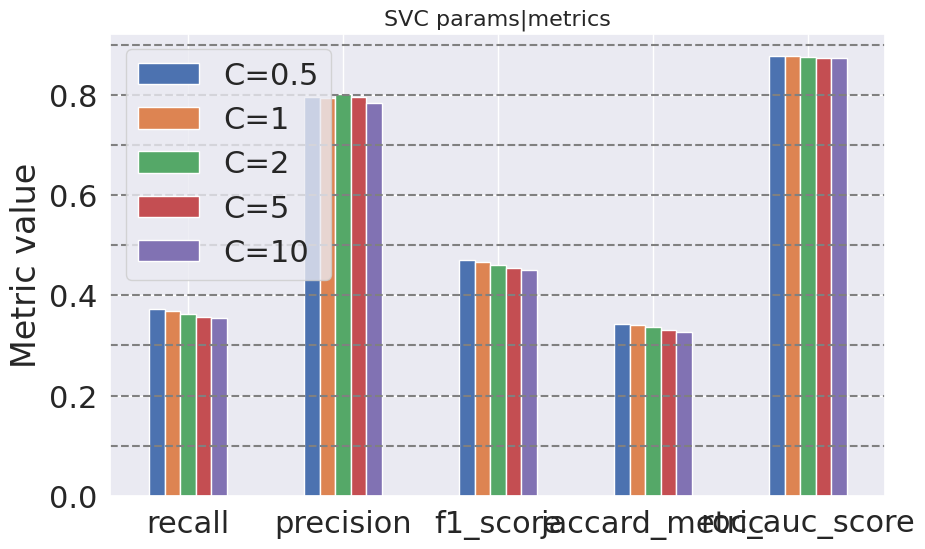

In [143]:
bar_svc = metrics_LinearSVC.T.plot.bar(figsize=(10,6))
bar_svc.set_title('SVC params|metrics', fontdict={'fontsize': 16, 'fontweight': 'medium'})
bar_svc.set_ylabel('Metric value')
process_plot(bar_svc)
bar_svc.figure.savefig('svc.png', facecolor='w',bbox_inches = 'tight')

In [144]:
metrics_MNB

recall  precision  f1_score  jaccard_metric  roc_auc_score
alpha=0.05   0.186045   0.929663  0.291045        0.185338       0.832435
alpha=0.01   0.312764   0.827729  0.433320        0.299978       0.875737
alpha=0.005  0.313671   0.824691  0.434311        0.300659       0.875384
alpha=0.003  0.307838   0.856948  0.429869        0.295800       0.872313
alpha=0.001  0.293070   0.854577  0.416490        0.283250       0.862629

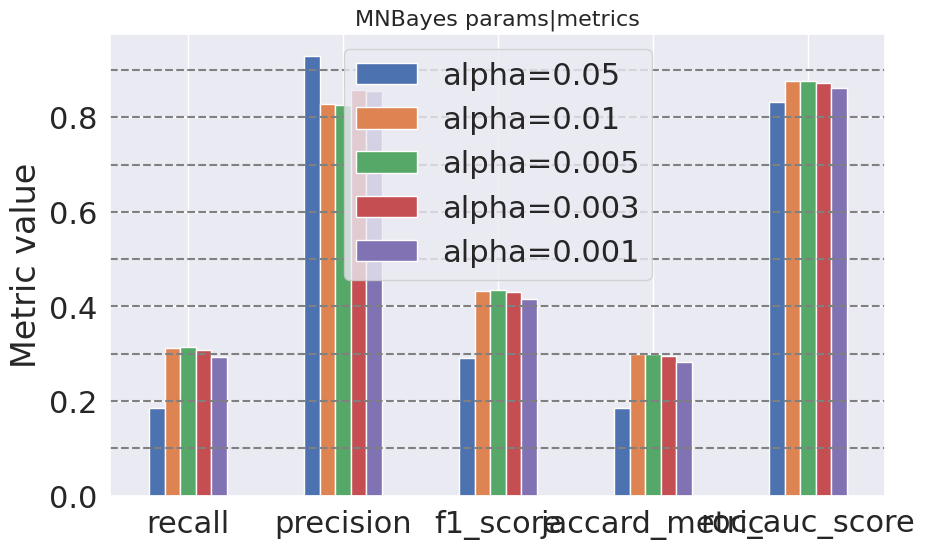

In [145]:
bar_mnb = metrics_MNB.T.plot.bar(figsize=(10,6))
bar_mnb.set_title('MNBayes params|metrics', fontdict={'fontsize': 16, 'fontweight': 'medium'})
bar_mnb.set_ylabel('Metric value')
process_plot(bar_mnb)
bar_mnb.figure.savefig('mnb.png', facecolor='w',bbox_inches = 'tight')

In [146]:
!pip install datasets

SVC + BERT embeddings

In [147]:
import torch
from datasets import Dataset
torch_y = torch.from_numpy(y_train.values)
labels = torch_y.to(torch.float)
labels

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

In [148]:
x_train_bert = df_train.plot_describe
x_val_bert  = df_val.plot_describe
x_test_bert = df_test.plot_describe

In [149]:
x_train_bert

1027    A sadistic serial killer, Patrick Channing (Je...
611     In Kotzebue, Alaska, bush pilot Mike Wein (Way...
3593    Rozat "Rusty" Sabich is a prosecutor and the r...
4036    In the South Seas, a volcano explodes, eventua...
4275    In 2011, a deadly pathogenic virus has killed ...
                              ...                        
1758    On his wedding anniversary, Han Chul-min (Jang...
2028    Hari (Sunil), a young businessman and Neha (Ra...
2833    The mysterious Green Knight appears before Kin...
4799    A man comes out of the office of "Garfield Inv...
872     Kevin Lenahan is an African-American con man w...
Name: plot_describe, Length: 2976, dtype: object

In [150]:
tf_val = pd.DataFrame()
tf_val['text'] = x_val_bert

tf_train = pd.DataFrame()
tf_train['text'] = x_train_bert

tf_test = pd.DataFrame()
tf_test['text'] = x_test_bert

In [151]:
from transformers import AutoModel,AutoTokenizer
import torch
import torch.nn.functional as F
from tqdm import tqdm

In [152]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state.detach().cpu()
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )

In [153]:
tf_train_bert = pd.DataFrame()
tf_train_bert['text'] = x_val_bert
tf_train_bert

text
338   A pushy newspaper reporter Eddie Crane (Ned Sp...
2352  Based on the 1963 book by Robert MacLeod,[2] t...
3426  Jeet Johar, is a ruthless Indo-Canadian gangst...
2194  The film begins with scenes of life in Wyoming...
4931  A millionaire is murdered at a séance at a for...
...                                                 ...
933   Verden Fell (Vincent Price) is both mournful a...
1652  While on the phone with his girlfriend Jill, w...
165   Five young people decide that life is not wort...
748   Charlie Bellow, a polite, kind-hearted young m...
2479  English aristocrat John Morgan is captured, en...

[992 rows x 1 columns]

In [154]:
df_val_bert = pd.DataFrame()
df_val_bert['text'] = x_val_bert
df_val_bert

text
338   A pushy newspaper reporter Eddie Crane (Ned Sp...
2352  Based on the 1963 book by Robert MacLeod,[2] t...
3426  Jeet Johar, is a ruthless Indo-Canadian gangst...
2194  The film begins with scenes of life in Wyoming...
4931  A millionaire is murdered at a séance at a for...
...                                                 ...
933   Verden Fell (Vincent Price) is both mournful a...
1652  While on the phone with his girlfriend Jill, w...
165   Five young people decide that life is not wort...
748   Charlie Bellow, a polite, kind-hearted young m...
2479  English aristocrat John Morgan is captured, en...

[992 rows x 1 columns]

In [155]:
BATCH_SIZE = 4

class EmbedDataset(torch.utils.data.Dataset):
    def __init__(self,df):
        self.df = df.reset_index(drop=True)
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        text = self.df.loc[idx,"text"]
        tokens = tokenizer(
                text,
                None,
                add_special_tokens=True,
                padding='max_length',
                truncation=True,
                max_length=MAX_LEN,return_tensors="pt")
        tokens = {k:v.squeeze(0) for k,v in tokens.items()}
        return tokens

In [156]:
def create_dataloader(df):
    ds = EmbedDataset(df)
    return torch.utils.data.DataLoader(ds,\
                        batch_size=BATCH_SIZE,\
                        shuffle=False)

In [157]:
embed_dataloader_train = create_dataloader(tf_train)
embed_dataloader_val = create_dataloader(tf_val)
embed_dataloader_test = create_dataloader(tf_test)

In [158]:
tokenizer = None
MAX_LEN = 640

def get_embeddings(embed_dataloader, MODEL_NM='', MAX=640, BATCH_SIZE=4):
    global tokenizer, MAX_LEN
    DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AutoModel.from_pretrained( MODEL_NM )
    tokenizer = AutoTokenizer.from_pretrained( MODEL_NM )
    MAX_LEN = MAX

    model = model.to(DEVICE)
    model.eval()
    all_train_text_feats = []
    for batch in tqdm(embed_dataloader, total=len(embed_dataloader)):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        with torch.no_grad():
            model_output = model(input_ids=input_ids,attention_mask=attention_mask)
        sentence_embeddings = mean_pooling(model_output, attention_mask.detach().cpu())
        # Normalize the embeddings
        sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        sentence_embeddings =  sentence_embeddings.squeeze(0).detach().cpu().numpy()
        all_train_text_feats.extend(sentence_embeddings)
    all_train_text_feats = np.array(all_train_text_feats)
    return all_train_text_feats

In [159]:
#MODEL_NM = '/kaggle/input/huggingface-roberta-variants/archive/roberta-base/roberta-base'
MODEL_NM = 'cardiffnlp/twitter-roberta-base-emotion'
train_text_feats = get_embeddings(embed_dataloader_train, MODEL_NM, MAX=512)
val_text_feats = get_embeddings(embed_dataloader_val, MODEL_NM, MAX=512)
test_text_feats = get_embeddings(embed_dataloader_test, MODEL_NM, MAX=512)

Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 744/744 [01:53<00:00,  6.53it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 248/248 [00:36<00:00,  6.71it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream tas

In [160]:
metrics_LinearSVC = pd.DataFrame()

In [161]:
for param in tqdm([0.1, 0.2, 0.5, 1, 2, 5, 10]):
    calibrated_clf = CalibratedClassifierCV(LinearSVC(C=param))
    clf = OneVsRestClassifier(calibrated_clf).fit(train_text_feats, y_train)
    svc_prediction = np.array(clf.predict_proba(val_text_feats))
    save_results_iter(metrics_LinearSVC, svc_prediction, y_val, 'C', param)

  0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 14%|█▍        | 1/7 [00:15<01:35, 15.86s/it]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 86%|████████▌ | 6/7 [02:28<00:30, 30.67s/it]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

RoBERTa+SVC trained

In [162]:
metrics_LinearSVC

recall  precision  f1_score  jaccard_metric  roc_auc_score
C=0.1  0.136461   0.578853  0.200393        0.123518       0.859624
C=0.2  0.155886   0.572604  0.226854        0.141592       0.868485
C=0.5  0.184767   0.601790  0.262355        0.166995       0.875844
C=1    0.200574   0.619793  0.280788        0.182206       0.878701
C=2    0.206448   0.590877  0.283029        0.185391       0.879430
C=5    0.212497   0.573649  0.284566        0.188903       0.878267
C=10   0.202279   0.519299  0.270258        0.180895       0.875981

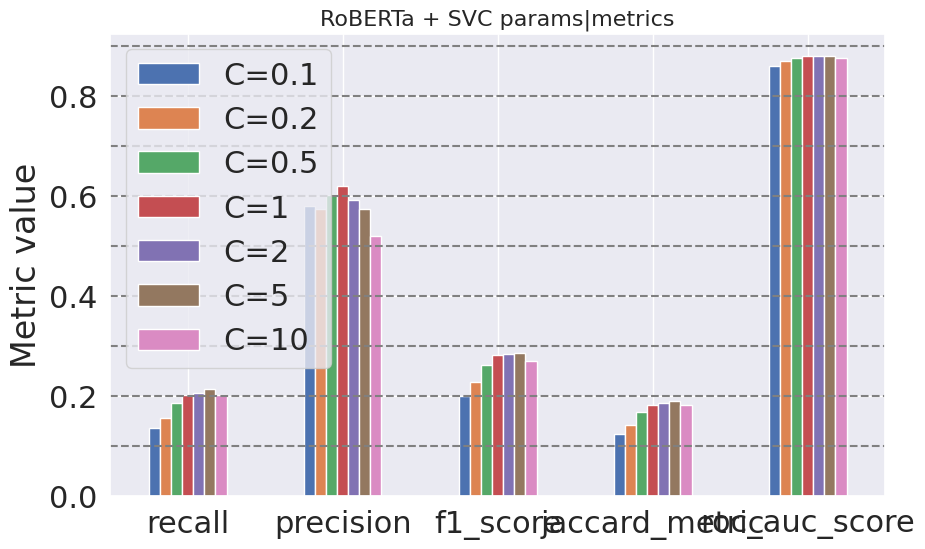

In [163]:
bar_svc = metrics_LinearSVC.T.plot.bar(figsize=(10,6))
bar_svc.set_title('RoBERTa + SVC params|metrics', fontdict={'fontsize': 16, 'fontweight': 'medium'})
bar_svc.set_ylabel('Metric value')
process_plot(bar_svc)
bar_svc.figure.savefig('deberta+svc.png', facecolor='w',bbox_inches = 'tight')

In [164]:
class_names = y_train.keys()
class_names

Index(['action', 'adventure', 'comedy', 'crime', 'crime drama', 'drama',
       'film noir', 'horror', 'musical', 'mystery', 'romance',
       'romantic comedy', 'science fiction', 'thriller', 'unknown', 'western'],
      dtype='object')

In [165]:
y_train

action  adventure  comedy  crime  crime drama  drama  film noir  horror  \
1027       0          0       0      0            0      0          0       1   
611        0          0       0      0            0      1          0       0   
3593       0          0       0      0            1      0          0       0   
4036       0          0       0      0            0      0          0       0   
4275       0          0       0      0            0      0          0       0   
...      ...        ...     ...    ...          ...    ...        ...     ...   
1758       0          0       0      0            0      0          0       0   
2028       0          0       0      0            0      0          0       0   
2833       0          1       0      0            0      0          0       0   
4799       0          0       0      0            0      0          0       0   
872        0          0       1      0            0      0          0       0   

      musical  mystery  romance  romantic comedy  science fiction  thriller  \
1027        0        0        0                0                0         0   
611         0        0        0                0                0         0   
3593        0        0        0                0                0         0   
4036        0        0        0                0                1         0   
4275        0        0        0                0                1         0   
...       ...      ...      ...              ...              ...       ...   
1758        0        0        0                0                0         1   
2028        0        0        1                0                0         0   
2833        0        0        0                0                0         0   
4799        0        1        0                0                0         0   
872         0        0        0                0                0         0   

      unknown  western  
1027        0        0  
611         0        0  
3593        0        0  
4036        0        0  
4275        0        0  
...       ...      ...  
1758        0        0  
2028        0        0  
2833        0        0  
4799        0        0  
872         0        0  

[2976 rows x 16 columns]

In [166]:
test_df = pd.DataFrame(x_test_bert)
test_df['text'] = x_test_bert.values
test_df['labels'] = y_test.agg(list, axis=1)
test_df.drop(['plot_describe'], axis=1, inplace=True)
test_df

text labels
3135  The story takes place in 1849. Captain Stanton...    NaN
2191  A man known only as the Virginian (Gary Cooper...    NaN
1295  A small bet by Chinna (Vishnu) during his chil...    NaN
2902  Due to a shortage of animals in American zoos ...    NaN
168   Harikrishnan, aka Hari, is a young civil engin...    NaN
...                                                 ...    ...
95    Alexander (Arjun) is a henchman who works for ...    NaN
2567  Three witnesses swear they saw Joe Reynolds mu...    NaN
3112  When kind-hearted delivery boy and self-acclai...    NaN
1721  Long time lovers Mohini(Poorna)and Harsha(Hars...    NaN
2413  With the Civil War nearing an end, rebel soldi...    NaN

[992 rows x 2 columns]

In [167]:
val_df = pd.DataFrame(x_val_bert)
val_df['text'] = x_val_bert.values
val_df['labels'] = y_val.agg(list, axis=1)
val_df.drop(['plot_describe'], axis=1, inplace=True)
val_df

text  \
338   A pushy newspaper reporter Eddie Crane (Ned Sp...   
2352  Based on the 1963 book by Robert MacLeod,[2] t...   
3426  Jeet Johar, is a ruthless Indo-Canadian gangst...   
2194  The film begins with scenes of life in Wyoming...   
4931  A millionaire is murdered at a séance at a for...   
...                                                 ...   
933   Verden Fell (Vincent Price) is both mournful a...   
1652  While on the phone with his girlfriend Jill, w...   
165   Five young people decide that life is not wort...   
748   Charlie Bellow, a polite, kind-hearted young m...   
2479  English aristocrat John Morgan is captured, en...   

                                                labels  
338   [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
2352  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]  
3426  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
2194  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]  
4931  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]  
...                                                ...  
933   [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]  
1652  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]  
165   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]  
748   [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
2479  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]  

[992 rows x 2 columns]

In [168]:
#!pip install -U tensorflow_probability==0.12.2
#!pip install -q -U simpletransformers
#import os
#os.environ["TOKENIZERS_PARALLELISM"] = "false"
#from simpletransformers.classification import MultiLabelClassificationModel

#model = MultiLabelClassificationModel('roberta', '/kaggle/input/d/vladislavkolesov/movie-genre-prediction-roberta-checkpoint/outputs/checkpoint-24660-epoch-3', num_labels=12, args={'train_batch_size':2, 'num_train_epochs': 3,'max_seq_length': 512, 'evaluate_during_training_steps':30000,'overwrite_output_dir': True, 'save_steps':24000,'use_multiprocessing':False, 'use_multiprocessing_for_evaluation':False})

In [169]:
!pip install lime
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)
# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline
# Set default font size
plt.rcParams['font.size'] = 24
from IPython.core.pylabtools import figsize
# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)
# Imputing missing values
#from sklearn.preprocessing import Imputer, MinMaxScaler
# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
# LIME for explaining predictions
import lime
import lime.lime_tabular


In [170]:
# Read in data into dataframes
train_features =  val_df['text']
test_features = test_df['text']
train_labels =  val_df['labels']
test_labels = test_df['labels']

In [171]:
y_train

action  adventure  comedy  crime  crime drama  drama  film noir  horror  \
1027       0          0       0      0            0      0          0       1   
611        0          0       0      0            0      1          0       0   
3593       0          0       0      0            1      0          0       0   
4036       0          0       0      0            0      0          0       0   
4275       0          0       0      0            0      0          0       0   
...      ...        ...     ...    ...          ...    ...        ...     ...   
1758       0          0       0      0            0      0          0       0   
2028       0          0       0      0            0      0          0       0   
2833       0          1       0      0            0      0          0       0   
4799       0          0       0      0            0      0          0       0   
872        0          0       1      0            0      0          0       0   

      musical  mystery  romance  romantic comedy  science fiction  thriller  \
1027        0        0        0                0                0         0   
611         0        0        0                0                0         0   
3593        0        0        0                0                0         0   
4036        0        0        0                0                1         0   
4275        0        0        0                0                1         0   
...       ...      ...      ...              ...              ...       ...   
1758        0        0        0                0                0         1   
2028        0        0        1                0                0         0   
2833        0        0        0                0                0         0   
4799        0        1        0                0                0         0   
872         0        0        0                0                0         0   

      unknown  western  
1027        0        0  
611         0        0  
3593        0        0  
4036        0        0  
4275        0        0  
...       ...      ...  
1758        0        0  
2028        0        0  
2833        0        0  
4799        0        0  
872         0        0  

[2976 rows x 16 columns]

In [172]:
class_names = y_train.keys()
class_names

Index(['action', 'adventure', 'comedy', 'crime', 'crime drama', 'drama',
       'film noir', 'horror', 'musical', 'mystery', 'romance',
       'romantic comedy', 'science fiction', 'thriller', 'unknown', 'western'],
      dtype='object')

In [173]:
import torch
from datasets import Dataset
torch_y = torch.from_numpy(y_train.values)
labels = torch_y.to(torch.float)
labels

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

In [174]:
test_df = pd.DataFrame(x_test_bert)
test_df['text'] = x_test_bert.values
test_df['labels'] = y_test.agg(list, axis=1)
test_df.drop(['plot_describe'], axis=1, inplace=True)
test_df

text labels
3135  The story takes place in 1849. Captain Stanton...    NaN
2191  A man known only as the Virginian (Gary Cooper...    NaN
1295  A small bet by Chinna (Vishnu) during his chil...    NaN
2902  Due to a shortage of animals in American zoos ...    NaN
168   Harikrishnan, aka Hari, is a young civil engin...    NaN
...                                                 ...    ...
95    Alexander (Arjun) is a henchman who works for ...    NaN
2567  Three witnesses swear they saw Joe Reynolds mu...    NaN
3112  When kind-hearted delivery boy and self-acclai...    NaN
1721  Long time lovers Mohini(Poorna)and Harsha(Hars...    NaN
2413  With the Civil War nearing an end, rebel soldi...    NaN

[992 rows x 2 columns]

In [175]:
val_df = pd.DataFrame(x_val_bert)
val_df['text'] = x_val_bert.values
val_df['labels'] = y_val.agg(list, axis=1)
val_df.drop(['plot_describe'], axis=1, inplace=True)
val_df

text  \
338   A pushy newspaper reporter Eddie Crane (Ned Sp...   
2352  Based on the 1963 book by Robert MacLeod,[2] t...   
3426  Jeet Johar, is a ruthless Indo-Canadian gangst...   
2194  The film begins with scenes of life in Wyoming...   
4931  A millionaire is murdered at a séance at a for...   
...                                                 ...   
933   Verden Fell (Vincent Price) is both mournful a...   
1652  While on the phone with his girlfriend Jill, w...   
165   Five young people decide that life is not wort...   
748   Charlie Bellow, a polite, kind-hearted young m...   
2479  English aristocrat John Morgan is captured, en...   

                                                labels  
338   [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
2352  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]  
3426  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
2194  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]  
4931  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]  
...                                                ...  
933   [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]  
1652  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]  
165   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]  
748   [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
2479  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]  

[992 rows x 2 columns]

In [176]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df_train.plot_clean)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)



In [177]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
classifier = MultinomialNB()
classifier.fit(X_train_tfidf, df_train.genre)
X_test_counts = count_vect.transform(df_test.genre)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
y_pred = classifier.predict(X_test_tfidf)
print(f"Accuracy Score: {accuracy_score(df_test.genre, y_pred)}")

Accuracy Score: 0.5403225806451613


In [189]:
df_eval = df_test.sample(10)

In [194]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(count_vect, tfidf_transformer, classifier)
row = df_eval.iloc[1]
sample_data = row['plot_clean']
explainer = LimeTextExplainer(class_names=df_train.genre)
exp = explainer.explain_instance(sample_data, pipeline.predict_proba, num_features=6, top_labels=1)
exp.show_in_notebook(text=False)

In [191]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(count_vect, tfidf_transformer, classifier)
row = df_eval.iloc[6]
sample_data = row['plot_clean']
explainer = LimeTextExplainer(class_names=df_train.genre)
exp = explainer.explain_instance(sample_data, pipeline.predict_proba, num_features=6, top_labels=1)
exp.show_in_notebook(text=False)


In [192]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(count_vect, tfidf_transformer, classifier)
row = df_eval.iloc[7]
sample_data = row['plot_clean']
explainer = LimeTextExplainer(class_names=df_train.genre)
exp = explainer.explain_instance(sample_data, pipeline.predict_proba, num_features=6, top_labels=1)
exp.show_in_notebook(text=False)

In [196]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(count_vect, tfidf_transformer, classifier)
row = df_eval.iloc[3]
sample_data = row['plot_clean']
explainer = LimeTextExplainer(class_names=df_train.genre)
exp = explainer.explain_instance(sample_data, pipeline.predict_proba, num_features=6, top_labels=1)
exp.show_in_notebook(text=False)